# Neural video part 1 - a glimpse of what you may get

This is the first of a series of $n$ notebooks concerning video processing for videos, mostly based on the 2020 IMPA course [Fundamentals and Trends in Vision and Image Processing 2020: The Year of Deep Video](http://lvelho.impa.br/ip20/) (by the way, that page has a lot of good information, so you might want to take a look there!).

We base on the aforementioned course, but the approach here will be different:

- First, we skip the very basics
    1. We will not tell you what a neural network is;
    2. We will not tell you what a convolutional neural network is
    3. We will not tell you how to do python programming, or have a detailed exposition about computational tensors.
    
Those are all important things to know. If you don't, there is plenty of good resources and materials that will go to some depth on them (the aforementioned course being one of those). You're invited so stick by here even if you're not comfortable though, for being uncomfotable is a marking sign of hunger for knowledge and knowing how to deal with it to one's favor is one the marking signs of the wise.

Another difference from the IMPA course is

- Second, we will start from the implementation, and then go to the theory.

We could just as well have gone the other way and started from the (very rich and beautiful) computing graphics theory, but the hope is that by seeing a cool application first, you'll feel motivated. That's not to mean well' see applications only on the beginning, but rather that we might see applications before seeing their theoretical fundaments. Also, at the onset I'm not sure how well I'll stick with the IMPA course syllabus, but that is for the future.

- Thirdly, it might be well to remember, I'm not an IMPA professor. Rather, I'm just a student of life trying to learn something and to pass some of what I've learnt to other like minded people.

That being said, let's get started.

## Action recognition

As a starting point, this is in good part adapted from the assingment 4 from the IMPA course and the [GluonCV tutorials](https://cv.gluon.ai/tutorials/index.html#action-recognition).

For the following we'll mostly be using 3 libraries, namely **[MXNet](https://mxnet.apache.org/versions/1.7.0/), [GluonCV](https://cv.gluon.ai/), [Decord](https://github.com/dmlc/decord)**. If you miss a more familiar name like TensorFlow or PyTorch, don't worry, we'll be seeing them in the future. 

The thing is, **GluonCV** has some of the best developed and easy to use video processing capabilities, and it just happens to work more simply with **MXNet** than with (say) **PyTorch**. But you shouldn't feel that much of a  difference (at least not at the level we'll be working with), since at the end all they do just is having ways to work with tensors and defining a network architecture. **Decord** is "just" a (pretty good and efficient) video reader (turns out, when you're working with thousands of images (frames) taken from hundreds of videos, being able to read them efficiently might become a bottleneck).

Training networks for video processing is too costly though. One could easily need terabytes of storage, plus more gigas of RAM than the ordinary person has and then, even with the best GPU, might need to wait a bit.

That's a little out of hand for our humble means, so we will instead load a pretrained architecture and play with it.

Firstly, you might want to install the required libraries, and, since we're at it, also do the required imports.
A sad point is.. there might be some conflicts running the code on google colab or jupyter :/
So you might want to run it separately.

In [ ]:
!pip install d2l==0.14.3
!pip install -U mxnet-cu101mkl==1.6.0.post0
!pip install --upgrade mxnet gluoncv
!pip install decord

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.data.vision import transforms

In [17]:
from gluoncv.data.transforms import video
from gluoncv import utils
from gluoncv.model_zoo import get_model

### **Part 1: Action Recognition**

Here the goal with be to use the pre-trained models to recognize action of videos.

### **Example: TSN on UCF101**

Here we will use a TSN trained model. TSN stands for [**Temporal Segment Network**](http://yjxiong.me/others/tsn/). It isn't an architecture, but more of a general algorithm that we'll get into more details later, but the gist of it is it uses an RGB CNN (CNN stands for Convolutional Neural Network) in parallel with an optical flow CNN, and those two run in parallel for multiple segments of the video, and are then combined with "segment consensus", to reach the desired output.

![TSN](pipeline.png)
(image ~~stolen~~ gracefully borrowed from http://yjxiong.me/others/tsn/)

We will go in more details about "optical flow" and "segment consensus" later, but roughly they just mean what it says - the "optical flow" giving a measure of the "movement" in the picture, and the "consensus" being a way to combine information from different segments.

In this example we use a model trained with TSN as in the GluonCV example [here](https://cv.gluon.ai/build/examples_action_recognition/demo_tsn_ucf101.html) but running in the decord environment. Check the tutorial page for more information about the dataset and the algorithm used.

First we load the video

In [ ]:
##First lets load the video
import decord

url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/v_Basketball_g01_c01.avi'
video_fname = utils.download(url)
vr = decord.VideoReader(video_fname)

282KB [00:00, 7645.23KB/s]             


To have a better grasp of it, see a few of the frames

In [ ]:
frame_id_list = range(0,len(vr),50)
video_frames = vr.get_batch(frame_id_list).asnumpy()

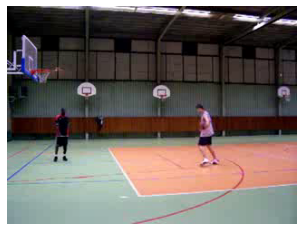

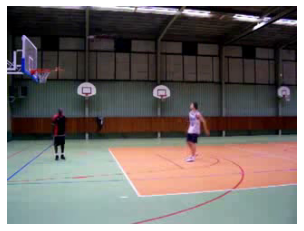

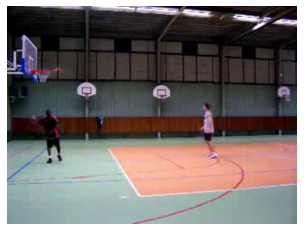

In [ ]:
for frame in video_frames:
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

The network we're using actually uses BGR images. Much like the default reading yielded by OpenCV (in case you know of it). By the way, [OpenCV](https://opencv.org/) is a very useful library - in case you haven't played with it, it's highly recommended. Here, we use it to simply convert the color schemes

In [ ]:
## The network we're using actually takes BGR images
import cv2
video_list = [cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) for frame in video_frames]

And then we do a simple transformation to normalize the dataset, by first cropping the videos into a 224x224, making them into $num\_channels \times height \times width$ tensors, and normalize with mean and standard deviation calculated across all [ImageNet](http://www.image-net.org/) images. 

The goal being to make the dataset more "model friendly", the transformation effected is model-dependant. If you don't do them, you should still expect to get overall good results (if the model is good, and the data is taken from approximately the same distribution it was taken, even if it doesn't have the same size, for instance), but you should also expect better results by running them (and, by the way, in case that doesn't happen, you shouldn't do them, as it'd represent unnecessary overhead).

In [ ]:
transform_fn = transforms.Compose([
    video.VideoCenterCrop(size=224),
    video.VideoToTensor(),
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
video_frames_transformed = transform_fn(video_list)

Then, we load the pre-trained model, here labeled "vgg16_ucf101". As per the (aforementioned) [gluon website](https://cv.gluon.ai/build/examples_action_recognition/demo_tsn_ucf101.html), "*UCF101 is an action recognition dataset of realistic action videos, collected from YouTube. With 13,320 short trimmed videos from 101 action categories, it is one of the most widely used dataset in the research community for benchmarking state-of-the-art video action recognition models.*". 

For the convolutional network it is used a [*vgg16*](https://arxiv.org/abs/1409.1556). "vgg" stands for "visual geometry group", the name of the group at the University of Oxford that developed it. It was used to win the ImageNet competition in 2014 and, despite having been outperformed by other architectures such as ResNet and Inception network, is still considered an excellent option for a vision model and is often used instead of (say) ResNet due to its simplicity, there existing good pre-trained models - also, not having the *skip connections* in vgg makes it easier to use for stuff like style transfer. 

![vgg16](vgg16.png)
(image ~~stolen~~ gracefully borrowed from neurohive.io)

In [ ]:
net = get_model('vgg16_ucf101', nclass=101, pretrained=True)

100%|██████████| 500159/500159 [00:10<00:00, 49862.97KB/s]


486864KB [00:09, 53152.43KB/s]                            


Then, perform the prediction. The code following should be self explanatory:

In [ ]:
## Return the Top 5 best possible classes
final_pred = 0
for _, frame_img in enumerate(video_frames_transformed):
    pred = net(nd.array(frame_img).expand_dims(axis=0))
    final_pred += pred
final_pred /= len(video_frames)

classes = net.classes
topK = 5
ind = nd.topk(final_pred, k=topK)[0].astype('int')
print('The input video is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(final_pred)[0][ind[i]].asscalar()))

The input video is classified to be
	[Basketball], with probability 0.934.
	[TennisSwing], with probability 0.062.
	[SoccerJuggling], with probability 0.003.
	[VolleyballSpiking], with probability 0.000.
	[ThrowDiscus], with probability 0.000.


Looks like it went well :)
Let's do some more interesting stuff then.

## Let's try the I3D on the Kinetics 400

We we're gonna do now is run a different (also pre-trained) network, namely the I3D (Inflated 3D network) in a random sample of videos from the Kinetics 400 dataset. 

From the Kinetics website, Kinetics is "*A collection of large-scale, high-quality datasets of URL links of up to 650,000 video clips that cover 400/600/700 human action classes, depending on the dataset version. The videos include human-object interactions such as playing instruments, as well as human-human interactions such as shaking hands and hugging. Each action class has at least 400/600/700 video clips. Each clip is human annotated with a single action class and lasts around 10 seconds.*"

We will need to download the Kinetics 400 urls from [here](https://deepmind.com/research/open-source/kinetics) (but I've already done it and ucompressed in the repo). Then, we select 30 random videos from there and download them (one would ideally work with the whole dataset, but that goes easily to a few hundred gigabytes).

Then we'll predict the actions with an I3D model. We proceed on steps

In [31]:
# We'll use youtube_dl and pafy to download the videos, and pandas to read the Kinetics csv
!pip install youtube_dl
!pip install pafy
import pafy
import pandas as pd

In [72]:
from decord import VideoReader

def get_youtube_cap(url):
    play = pafy.new(url).streams[-1] # we will take the lowest quality stream
    assert play is not None # makes sure we get an error if the video failed to load
    return VideoReader(play.url)

In [55]:
#@ Use this for working with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# Get the video links
# !wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics400.tar.gz -O - | tar xz

In [ ]:
pool_size = 30

videos        = pd.read_csv("drive/MyDrive/Colab Notebooks/kinetics400/validate.csv")
videos_sample = vs.sample(n = pool_size, random_state = 2)
videos_sample

In [73]:
# Function to preprocess the videos, follows the GluonCV tutorial

transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
frame_id_list = range(0, 64, 2)

def get_preprocessed(video_file):
  v = VideoReader(video_file, width = 224, height = 224)
  
  clip_input = v.get_batch(frame_id_list).asnumpy()
  clip_input = [clip_input[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

  clip_input = transform_fn(clip_input)
  clip_input = np.stack(clip_input, axis=0)
  clip_input = clip_input.reshape((-1,) + (32, 3, 224, 224))
  clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
  return clip_input

In [93]:
!mkdir sample_kinetics400
base_url = "https://www.youtube.com/watch?v="

video_files = []
for index, row in videos_sample.iterrows():
  try:
    url =  base_url + row['youtube_id']
    print(url)
    play = pafy.new(url).streams[-1]
    fname = "sample_kinetics400/"+str(index)+".mp4"
    play.download(filepath = fname)
    video_files.append(fname)
    print(f"saved at {fname}")
  except:
    videos_sample = videos_sample[videos_sample.youtube_id != row['youtube_id']]
    pass

mkdir: cannot create directory ‘sample_kinetics400’: File exists
https://www.youtube.com/watch?v=2bcqsJ-Om-8


ERROR: Video unavailable


https://www.youtube.com/watch?v=WmSRWT36LWo

saved at sample_kinetics400/9760.mp4
https://www.youtube.com/watch?v=1FEcfy-moBM

saved at sample_kinetics400/924.mp4
https://www.youtube.com/watch?v=fZ0IO--Q-ZQ

saved at sample_kinetics400/12479.mp4
https://www.youtube.com/watch?v=jQ939TWnXEY

saved at sample_kinetics400/13548.mp4
https://www.youtube.com/watch?v=bbu7lxDJ3_A

saved at sample_kinetics400/11364.mp4
https://www.youtube.com/watch?v=DYcbS0QgOs8


ERROR: Video unavailable



saved at sample_kinetics400/4368.mp4
https://www.youtube.com/watch?v=-hFa8jTSaJw
https://www.youtube.com/watch?v=v1E7FRUo6YU

saved at sample_kinetics400/16691.mp4
https://www.youtube.com/watch?v=syLS5UqF9ZY

saved at sample_kinetics400/16173.mp4
https://www.youtube.com/watch?v=HmCUN62Nke0
https://www.youtube.com/watch?v=fEh_nhChKEk

saved at sample_kinetics400/12369.mp4
https://www.youtube.com/watch?v=3KMngq0EbG8

saved at sample_kinetics400/1497.mp4
https://www.youtube.com/watch?v=iODOiyjA_04

saved at sample_kinetics400/13244.mp4
https://www.youtube.com/watch?v=vM2S_DBykhU

saved at sample_kinetics400/16780.mp4
https://www.youtube.com/watch?v=xxqkCP1oTis

saved at sample_kinetics400/17503.mp4
https://www.youtube.com/watch?v=bh6Cvz2orzQ

saved at sample_kinetics400/11390.mp4
https://www.youtube.com/watch?v=-ABVyFqo4rc

saved at sample_kinetics400/239.mp4
https://www.youtube.com/watch?v=oNx68xPoPSA

saved at sample_kinetics400/14901.mp4
https://www.youtube.com/watch?v=DvY0sNS_hWM

sa

Now we load the model. As mentioned, we'll be first using an [I3D model](https://arxiv.org/abs/1705.07750), which is basically a 2 streamed 3D CNN (that is, a CNN with 3D kernels rather than 2, the third dimension being time) that "inflates" the (painstakingly learnt) parameters from 2D CNNs. 2 streamed here means it, much like the TSN we previously looked at, has 2 "streams", one RGB and an optical flow one.

It is an improvement on previous 3D CNNs by making use of ImageNet trained models as a starting point (with that inflation thing). I3D was (as you can read from the article) trained with an inception model, so that's what we use

In [62]:
model_name = 'i3d_inceptionv1_kinetics400'
net = get_model(model_name, nclass=400, pretrained=True)
print('%s model is successfully loaded.' % model_name)

51278KB [00:01, 33213.88KB/s]                           


i3d_inceptionv1_kinetics400 model is successfully loaded.


In [94]:
classes = net.classes
topK= 5

for i, row in enumerate(videos_sample.iterrows()):
  clip_input = get_preprocessed(video_files[i])
  pred = net(nd.array(clip_input))
  ind = nd.topk(pred, k=topK)[0].astype('int')
  print(f"Video named {video_files[i]} with original label: {row[1]['label']} \n is classified as (class, probability)")
  for i in range(topK):
    print('\t[%s], %.3f' % (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

Video named sample_kinetics400/9760.mp4 with original label: tasting beer 
 is classified as (class, probability)
	[tasting_beer], 0.946
	[drinking_beer], 0.024
	[opening_bottle], 0.015
	[drinking], 0.008
	[drinking_shots], 0.005
Video named sample_kinetics400/924.mp4 with original label: assembling computer 
 is classified as (class, probability)
	[flying_kite], 0.064
	[smoking_hookah], 0.054
	[somersaulting], 0.033
	[mopping_floor], 0.028
	[cleaning_floor], 0.026
Video named sample_kinetics400/12479.mp4 with original label: playing recorder 
 is classified as (class, probability)
	[playing_recorder], 0.544
	[playing_trumpet], 0.117
	[playing_saxophone], 0.094
	[playing_clarinet], 0.041
	[playing_trombone], 0.039
Video named sample_kinetics400/13548.mp4 with original label: skateboarding 
 is classified as (class, probability)
	[answering_questions], 0.043
	[sign_language_interpreting], 0.023
	[beatboxing], 0.020
	[lunge], 0.017
	[juggling_balls], 0.017
Video named sample_kinetics400/

You can see that, although the classifier gets confused somewhat often, it gets it right a good amount of the time. It's a difficult problem - 400 classes is a lot. But, although model isn't the latest, the improvements that there are to date aren't (to the best of my knowledge) quite substantial. You could somewhat improve with using a SlowFast architecture (about which we'll have more to talk about later), but not all that much.

Well then, let's turn to a last application, and call it a day.

### **Depth Prediction**

An impressive application of deep learning in computer vision is depth estimation from a single view. For that a model is trained using mono views combined with stereo views, in order to predict depth. After training the network the model seems to be capable to estimate the depth view from only a single image. Lets apply one of this models in a video. Consider the following example from the MIT Driving Scene Segmentation Dataset.

In [95]:
url = "https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4"
video_fname = utils.download(url)

100%|██████████| 27907/27907 [00:00<00:00, 41951.10KB/s]


In [96]:
vr = decord.VideoReader(video_fname)

(1080, 1920, 3)
599


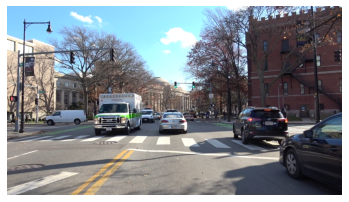

In [101]:
frame = vr[200]
print(frame.shape)
print(len(vr))
plt.imshow(frame.asnumpy())
plt.axis('off')
plt.show()

Using the Monodepth2 model pre-trained in the KITTI dataset, we create a video containing the depth view of the video from the above example. You can follow the examples from the Gluon website [1](https://cv.gluon.ai/build/examples_depth/demo_monodepth2.html) and [2](https://cv.gluon.ai/build/examples_depth/videos_monodepth2.html) for this. 

It's interesting that the model was trained in a different format than the one above, and it is also not quite a state of the art model (it doesn't use temporal information, for instance, but operates frame by frame) - but even so, it works remarkably well!

In [106]:
# Uisng this 'bridge' our video is read with the required format, with no greater effort
decord.bridge.set_bridge('mxnet')
vr = decord.VideoReader(video_fname)

In [103]:
feed_height = 192
feed_width = 640
original_height = 1080
original_width = 1920

transform = transforms.Compose([
  transforms.Resize(size=(feed_width, 360), keep_ratio=True),
  transforms.CenterCrop(size=(feed_width, feed_height)),
  transforms.ToTensor()])

In [104]:
model = get_model('monodepth2_resnet18_kitti_stereo_640x192', pretrained=True)

42433KB [00:01, 32001.56KB/s]                           


70344KB [00:01, 37945.19KB/s]



 33%|███▎      | 200/599 [02:07<03:58,  1.67it/s]

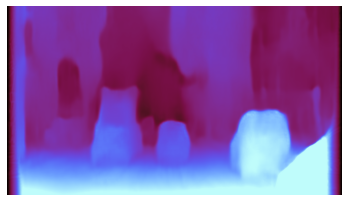


100%|██████████| 599/599 [06:11<00:00,  1.61it/s]


In [111]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from tqdm import tqdm

out = cv2.VideoWriter('mit_depth_2.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 30, (original_width, original_height))

for i, frame in enumerate(tqdm(vr)):
  frame = transform(frame)
  frame = frame.expand_dims(0)
  depth = model.predict(frame)
  disp = depth[("disp", 0)]
  disp_resized = mx.nd.contrib.BilinearResize2D(disp, height = original_height, width = original_width)

  # Compute depth estimation
  disp_resized_np = disp_resized.squeeze().asnumpy()
  vmax = np.percentile(disp_resized_np, 95)
  normalizer = mpl.colors.Normalize(vmin = disp_resized_np.min(), vmax = vmax)
  mapper = cm.ScalarMappable(norm = normalizer, cmap = 'magma')
  colormapped_im = (mapper.to_rgba(disp_resized_np)[:,:,:3] * 255).astype(np.uint8)
  image = cv2.cvtColor(colormapped_im, cv2.COLOR_RGB2BGR)
  out.write(image)

  if i == 200:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

out.release()

## **Next time**

We'll take a tour through some of the models for video processing. We'll look at of the common architectures and especially what is State of the Art for a couple common applications.

You'll see how neural networks for video processing has come a long way, and is finally maturing.

See you then o/